In [5]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

path = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(path)

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM_ import RTRBM as RTRBM_
from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RTRBM_no_bias import RTRBM_nobias
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *
%matplotlib inline


In [6]:
def gen_W(N_H, N_V, mu=[1.5, 0.4], sig=[0.05, 0.05], rand_assign=0, size_chunk = [0.9, 1.1], f=0.5):

    # initialze fully connected random weight matrix
    W = torch.zeros((N_H, N_V), dtype=torch.float)

    # Assign random sized populations to each N_H (how many connections has each N_H at connectivity=minimum connectivity)
    chunks = N_V * torch.ones(N_H - 1)
    while torch.sum(chunks) > N_V:
        chunks = torch.randint(low=int(size_chunk[0] * (N_V/N_H)), high=int(size_chunk[1] * (N_V/N_H)), size=(N_H-1,))
    chunks = torch.cat([torch.tensor([0]), torch.cat([chunks, torch.tensor([N_V - torch.sum(chunks)])])])
    chunks = [torch.sum(chunks[:h+1]) for h in range(N_H+1)]

    # Randomly assign N_V idx to each HU population (randomly can be changed with rand_assign)
    temp = torch.arange(N_V)
    rand_idx = torch.randperm(N_V)[:int(N_V * rand_assign)]
    temp[rand_idx] = rand_idx[torch.randperm(rand_idx.shape[0])]
    randperm = [ temp[chunks[h]:chunks[h+1]] for h in range(N_H)]

    # Define main populations
    idxh = torch.randperm(N_H)[:int(N_H * f)]

    for h in range(N_H):
        if torch.sum(h == idxh) == 1:
            W[h, randperm[h]] = -mu[0] + sig[0] * torch.randn(size=randperm[h].shape, dtype=torch.float)
        else:
            W[h, randperm[h]] = 0.7 * mu[0] + sig[0] * torch.randn(size=randperm[h].shape, dtype=torch.float)
    # shuffle
    idxh = torch.randperm(N_H)
    W = W[idxh, :]

    # Define sub-populations
    n_pop = len(mu)
    size_pop = torch.randint(low=1, high=N_H, size=(n_pop,))
    sub_con = torch.ones((N_H, N_H)) - torch.eye(N_H)[idxh, :]
    start = [0, 0]

    for n in range(n_pop):
        start = torch.randint(low=0, high=N_H, size=(1,2,))[0]
        while start[0] == start[1] or sub_con[start[0], start[1]] == 0:
            start = torch.randint(low=0, high=N_H, size=(1,2,))[0]
        sub_con[start[0], start[1]] = n + 1
        tempm = start.detach().clone()

        for i in range(size_pop[n]):
            # random select step -1, 0, 1
            step = torch.randint(low=-1, high=2, size=(1,2,))[0]

            # make sure its not diagonal
            while torch.abs(step[0]) == torch.abs(step[1]):
                step = torch.randint(low=-1, high=2, size=(1,2,))[0]

            temp = tempm + step
            j=0

            # make sure its not out of bounds and make sure its not already occupied
            while temp[0] < 0 or temp[0] > N_H-1 or temp[1] < 0 or temp[1] > N_H-1 or \
                    j>100 or sub_con[temp[0], temp[1]] == 0:
                # random select step -1, 0, 1
                step = torch.randint(low=-1, high=2, size=(1,2,))[0]

                # make sure step is not diagonal
                while torch.abs(step[0]) == torch.abs(step[1]):
                    step = torch.randint(low=-1, high=2, size=(1,2,))[0]
                temp = tempm + step
                j += 1

            if j<100:
                tempm = temp.detach().clone()
                sub_con[temp[0], temp[1]] = n + 1

    # take only the sub populations
    sub_con[sub_con<=1] = 0
    sub_conn = torch.zeros_like(W)

    # set to the right shape
    for h in idxh:
        sub_conn[:, randperm[h]] = sub_con[:, h].repeat(randperm[h].shape[0]).reshape([randperm[h].shape[0], N_H]).T

    # add to W
    for p in range(1, n_pop):
        W += (mu[p] + sig[p] * torch.randn(size=W.shape, dtype=torch.float)) * (sub_conn == p + 1)

    return W

In [73]:
def gen_U(N_H, nabla=2, connectivity=0):

    std = 500
    it=0
    while std > 10 or it<100:
        ## initialize parameters
        sparcity = 1 - connectivity
        sp = 1 - 1/N_H

        U = torch.eye(N_H) * torch.randn((N_H, N_H), dtype=torch.float)
        U = U[torch.randperm(N_H), :]
        # compute the number of zeros we need to have in the weight matrix to obtain the predefined connectivity
        sp = torch.sum(U==0)/U.numel()
        conn = 1 - sp
        n_zeros = int(torch.sum(U==0) - sparcity * U.numel())

        if n_zeros>0:
            # randomly add values to the weight matrix in order to obtain the predefined connectivity
            idx = torch.where(U.ravel() == 0)[0]
            idx = idx[torch.randperm(idx.shape[0])[:n_zeros]]
            U.ravel()[idx] = torch.randn(n_zeros, dtype=torch.float)
        else:
            print('Minimum connectivity is: '+str(conn))


        for i in range(N_H):
            idx = U[i, :] != 0
            if torch.sum(idx)>1:
                U[i, idx] = (U[i, idx] - torch.mean(U[i, idx])) / torch.std(U[i, idx])

            temp = torch.randn(N_H) * (U[i, :] != 0)
            if isinstance(nabla, list) or isinstance(nabla, torch.Tensor):
                if len(nabla) != N_H:
                    raise ValueError ('nabla should be an interger or list or torch.Tensor with length N_H')
                temp = nabla[i] * temp/torch.sum(temp)
            else:
                temp = nabla * temp/torch.sum(temp)
            U[i, :] += temp
        std = torch.std(U.ravel())
        it+=1
    if it == 100:
        raise ValueError ('Try again with different W')
    return U

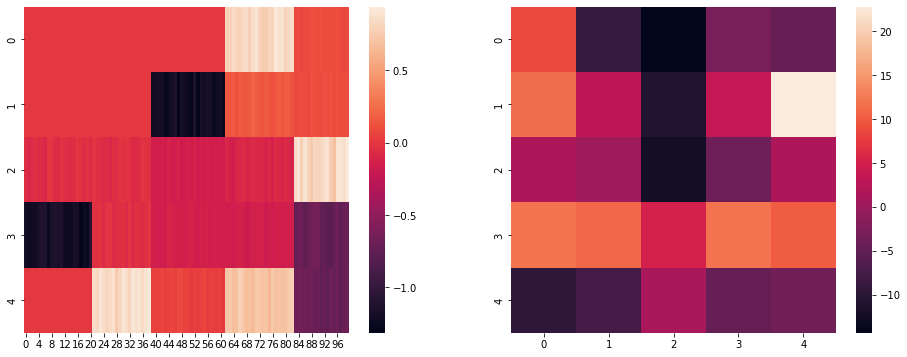

tensor([ 23.5457,  -2.3470, -31.5755,   4.1848,  26.2327])
tensor([-22.2263,  29.8344, -12.8625,  49.8433, -24.5482])
tensor([ 18.9748, -23.1863,   6.7151, -44.6261,  19.3915])


C:\Users\sebas\AppData\Local\Temp/ipykernel_36972/4023684566.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float, device='cpu')


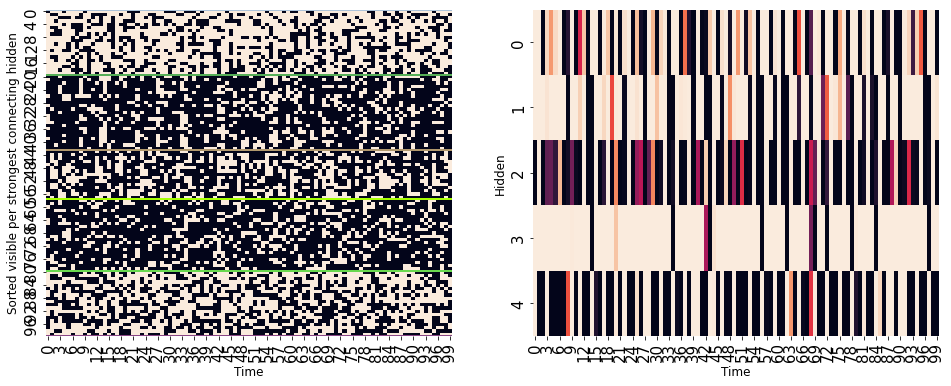

In [74]:
N_H, N_V = 5, 100
mu = [1.2, 0.7, 0.15 , 0.1, 0.05, -0.05, -0.1, -0.15, -0.7]
sig = [0.05, 0.04, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.04]
rand_assign = 0
size_chunk = [0.8, 1.2]

W = gen_W(N_H, N_V, mu=mu, sig=sig, rand_assign=rand_assign, size_chunk = size_chunk, f=0.5)

nabla = torch.randn(N_H) + 5*torch.sign(torch.sum(W,1))
U = gen_U(N_H, nabla=-torch.sum(W,1)-nabla, connectivity=1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(W, ax=ax[0])
sns.heatmap(U, ax=ax[1])
plt.show()

print(torch.sum(U,0))
print(torch.sum(U, 1))
print(torch.sum(W, 1))

#print(torch.sum(W, 1), torch.sum(W, 0))

# Initialize rtrbm
T = 100

rtrbm_init = RTRBM(torch.zeros(N_V, T), N_H=N_H, device='cpu')
rtrbm_init.W = W
rtrbm_init.U = U
rtrbm_init.b_H = torch.zeros(1, N_H, dtype=torch.float)
rtrbm_init.b_V = torch.zeros(1, N_V, dtype=torch.float)
rtrbm_init.b_init = torch.zeros(1, N_H, dtype=torch.float)

n_batches = 1
data = torch.zeros(N_V, T, n_batches)
rt = torch.zeros(N_H, T, n_batches)
for batch in range(n_batches):
    v_start = (torch.rand(N_V) > 0.7)*1.0
    data[:, :, batch], rt[:, :, batch] = rtrbm_init.sample(v_start.type(torch.float), chain=T, pre_gibbs_k=100, gibbs_k=100, mode=1, disable_tqdm=True)

data = torch.tensor(data, dtype=torch.float, device='cpu')
#sns.heatmap(data[:, :, 0])
#plt.show()

#idx = plot_spikes_grouped_by_HU(W, data[:, :, 0].cpu(), rt[:, :, 0].cpu())
#sns.heatmap(torch.sigmoid(W))
plt.show()
idx = plot_spikes_grouped_by_HU(W, data[:, :, 0].cpu(), rt[:, :, 0].cpu())

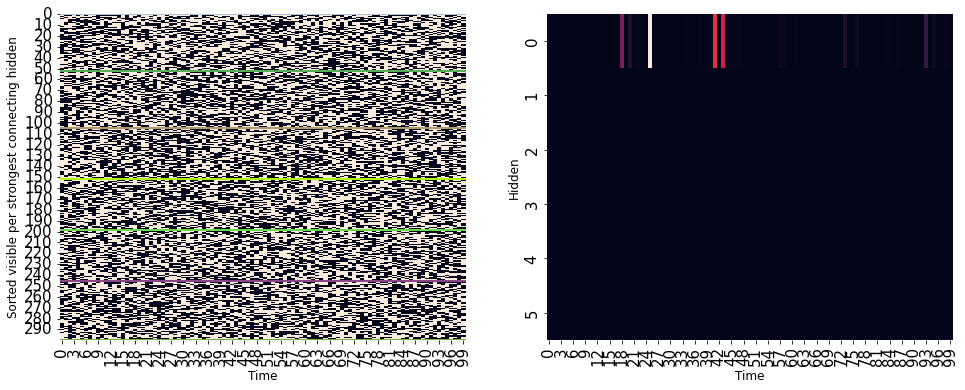

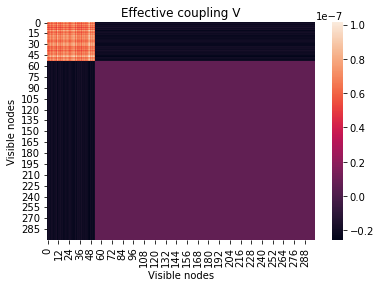

In [107]:
idx = plot_spikes_grouped_by_HU(W, data[:, :, 0].cpu(), rt[:, :, 0].cpu())

# variance matrix
var_h_matrix = torch.reshape(torch.var(rt[:, :, 0], 1).repeat(W.shape[1]), [W.shape[1], W.shape[0]]).T

# effective coupling W
Je_W = torch.mm(W[:, idx].T, W[:, idx] * var_h_matrix)/W.shape[1]**2

sns.heatmap(Je_W)
plt.ylabel("Visible nodes")
plt.xlabel("Visible nodes")
plt.title('Effective coupling V')
plt.tick_params(axis='both', which='major')

In [37]:
def gen_W(N_H, N_V, nabla=2, connectivity=0, rand_assign=1, size_chunk=[0.5, 1.5]):
    sp = 1 - 1/N_H

    # initialze fully connected random weight matrix
    W = nabla * torch.zeros((N_H, N_V), dtype=torch.float)

    # Assign random sized populations to each N_H (how many connections has each N_H at connectivity=minimum connectivity)
    chunks = N_V * torch.ones(N_H - 1)
    while torch.sum(chunks) > N_V:
        chunks = torch.randint(low=int(0.5 * (N_V/N_H)), high=int(1.5 * (N_V/N_H)), size=(N_H-1,))
    chunks = torch.cat([torch.tensor([0]), torch.cat([chunks, torch.tensor([N_V - torch.sum(chunks)])])])

    # Randomly assign N_V idx to each HU population (randomly can be changed with rand_assign)
    temp = torch.arange(N_V)
    rand_idx = torch.randperm(N_V)[:int(N_V * rand_assign)]
    temp[rand_idx] = rand_idx[torch.randperm(rand_idx.shape[0])]
    randperm = [ temp[torch.sum(chunks[:h+1]) : chunks[h+1] + torch.sum(chunks[:h+1])] for h in range(N_H)]

    for h in range(N_H):
        W[h, randperm[h]] = nabla * torch.randn(size=randperm[h].shape, dtype=torch.float)

    # compute the number of zeros we need to have in the weight matrix to obtain the predefined connectivity
    sp = torch.sum(W==0)/W.numel()
    conn = 1 - sp
    n_zeros = int(torch.sum(W==0) - sparcity * W.numel())

    if n_zeros>0:
        # randomly add values to the weight matrix in order to obtain the predefined connectivity
        idx = torch.where(W.ravel() == 0)[0]
        idx = idx[torch.randperm(idx.shape[0])[:n_zeros]]
        W.ravel()[idx] = nabla * torch.randn(n_zeros, dtype=torch.float)
    else:
        print('Minimum connectivity is: '+str(conn))

    idxh = torch.randperm(N_H)[:int(N_H/2)]
    for i in range(N_H):
        idx = W[i, :] != 0
        if torch.sum(idx)>1:
            W[i, idx] = (W[i, idx] - torch.mean(W[i, idx])) / torch.std(W[i, idx])

        temp = torch.randn(N_V) * W[i, :] != 0
        temp = nabla * temp/torch.sum(temp)

        if torch.sum(idxh == i)==1:
            W[i, :] -= temp
        else:
            W[i, :] += temp

    return W

def gen_W1(N_H, N_V, nabla=1, connectivity=0, rand_assign=1, size_chunk=[0.9, 1.1]):
    ## initialize parameters
    sparcity = 1 - connectivity

    sp = 1 - 1/N_H

    # initialze fully connected random weight matrix
    W = nabla * torch.zeros((N_H, N_V), dtype=torch.float)

    # Assign random sized populations to each N_H (how many connections has each N_H at connectivity=minimum connectivity)
    chunks = N_V * torch.ones(N_H - 1)
    while torch.sum(chunks) > N_V:
        chunks = torch.randint(low=int(size_chunk[0] * (N_V/N_H)), high=int(size_chunk[1] * (N_V/N_H)), size=(N_H-1,))
    chunks = torch.cat([torch.tensor([0]), torch.cat([chunks, torch.tensor([N_V - torch.sum(chunks)])])])

    # Randomly assign N_V idx to each HU population (randomly can be changed with rand_assign)
    temp = torch.arange(N_V)
    rand_idx = torch.randperm(N_V)[:int(N_V * rand_assign)]
    temp[rand_idx] = rand_idx[torch.randperm(rand_idx.shape[0])]
    randperm = [ temp[torch.sum(chunks[:h+1]) : chunks[h+1] + torch.sum(chunks[:h+1])] for h in range(N_H)]

    for h in range(N_H):
        W[h, randperm[h]] = nabla * torch.rand(size=randperm[h].shape, dtype=torch.float)

    # compute the number of zeros we need to have in the weight matrix to obtain the predefined connectivity
    sp = torch.sum(W==0)/W.numel()
    conn = 1 - sp
    n_zeros = int(torch.sum(W==0) - sparcity * W.numel())

    if n_zeros>0:
        # randomly add values to the weight matrix in order to obtain the predefined connectivity
        idx = torch.where(W.ravel() == 0)[0]
        idx = idx[torch.randperm(idx.shape[0])[:n_zeros]]
        W.ravel()[idx] = nabla * torch.rand(n_zeros, dtype=torch.float)
    else:
        print('Minimum connectivity is: '+str(conn))

    idxh = torch.randperm(N_H)[:int(N_H/2)]
    for i in range(N_H):
        idx = W[i, :] != 0
        if torch.sum(idx)>1:
            W[i, idx] = (W[i, idx] - torch.mean(W[i, idx])) / torch.std(W[i, idx])

        temp = torch.randn(N_V) * (W[i, :] != 0)/10
        temp = nabla * temp/torch.sum(temp)
        if torch.sum(idxh == i)==1:
            W[i, :] -= temp
        else:
            W[i, :] += temp
    return W

def gen_U(N_H, nabla=2, connectivity=0):
    ## initialize parameters
    sparcity = 1 - connectivity
    sp = 1 - 1/N_H

    U = torch.eye(N_H) * nabla * torch.randn((N_H, N_H), dtype=torch.float)
    U = U[torch.randperm(N_H), :]
    # compute the number of zeros we need to have in the weight matrix to obtain the predefined connectivity
    sp = torch.sum(U==0)/U.numel()
    conn = 1 - sp
    n_zeros = int(torch.sum(U==0) - sparcity * U.numel())

    if n_zeros>0:
        # randomly add values to the weight matrix in order to obtain the predefined connectivity
        idx = torch.where(U.ravel() == 0)[0]
        idx = idx[torch.randperm(idx.shape[0])[:n_zeros]]
        U.ravel()[idx] = nabla * torch.randn(n_zeros, dtype=torch.float)
    else:
        print('Minimum connectivity is: '+str(conn))

    idxh = torch.randperm(N_H)[:int(N_H/2)]

    for i in range(N_H):
        idx = U[i, :] != 0
        if torch.sum(idx)>1:
            U[i, idx] = (U[i, idx] - torch.mean(U[i, idx])) / torch.std(U[i, idx])

        temp = torch.randn(N_H) * (U[i, :] != 0)
        temp = nabla * temp/torch.sum(temp)
        if torch.sum(idxh == i)==1:
            U[i, :] -= temp
        else:
            U[i, :] += temp

    return U

In [25]:
def plot_spikes_grouped_by_HU(W, vt, rt, fontsize=12):
    # W.shape = [H, V]

    colors_list = list(colors._colors_full_map.values())
    N_V, T = vt.shape
    N_H = rt.shape[0]
    stongest_connecting_HU = torch.zeros(N_V)

    for i in range(N_V):
        # returns the index of the strongest connecting HU per visible, according to W
        stongest_connecting_HU[i] = torch.argmax(torch.abs(W[:, i]))

    # sort visibles to their strongest connection HU
    idx = torch.argsort(stongest_connecting_HU)
    num = torch.zeros(N_H+1, dtype=int)
    for i in range(N_H):
        # determine how many visibles are connected to hidden i
        num[i+1] = num[i] + torch.count_nonzero(stongest_connecting_HU == i)

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(vt[idx,:], ax = ax[0], cbar=False)
    ax[0].set_xlabel('Time', fontsize=fontsize)
    ax[0].set_ylabel('Sorted visible per strongest connecting hidden', fontsize=fontsize)
    ax[0].tick_params(axis='both', which='major', labelsize=15)

    for x, i in enumerate(num):
        ax[0].hlines(i, 0, T, colors = colors_list[x], linewidth=2)

    sns.heatmap(rt, ax = ax[1], cbar=False)
    ax[1].set_xlabel('Time', fontsize=fontsize)
    ax[1].set_ylabel('Hidden', fontsize=fontsize)
    ax[1].tick_params(axis='both', which='major', labelsize=15)

    plt.show()
    return idx

In [206]:
def reshuffle(W_original, W_train, U_original, U_train):

    corr = np.zeros((N_H, N_H))
    shuffle_idx = np.zeros((N_H))
    for i in range(N_H):
        for j in range(N_H):
            corr[i, j] = np.correlate(W_original[i,:], W_train[j,:])
        shuffle_idx[i] = np.argmax(corr[i,:])

    W_train = W_train[shuffle_idx, :]
    U_train = U_train[shuffle_idx, :]
    U_train = U_train[:, shuffle_idx]

    fig, ax = plt.subplots(2, 1, figsize=(8,8))
    ax[0].scatter(W_original.ravel(), W_train.ravel())
    ax[0].set_xlabel('Original')
    ax[0].set_ylabel('Trained')
    ax[0].set_title('r-value:'+str(r_W))
    ax[1].scatter(U_original.ravel(), U_train.ravel())
    ax[1].set_xlabel('Original')
    ax[1].set_ylabel('Trained')
    ax[1].set_title('r-value:'+str(r_U))

    return W_original, W_train, U_original, U_train

tensor([-174.4937,  -72.6550,  -79.0549, -169.1934,   71.1209,   68.2925],
       device='cuda:0') tensor([12.6135, -2.6402, -2.5494, -0.7245,  3.1514,  3.3832], device='cuda:0')
tensor(0.2005, device='cuda:0') tensor(0.0101, device='cuda:0')


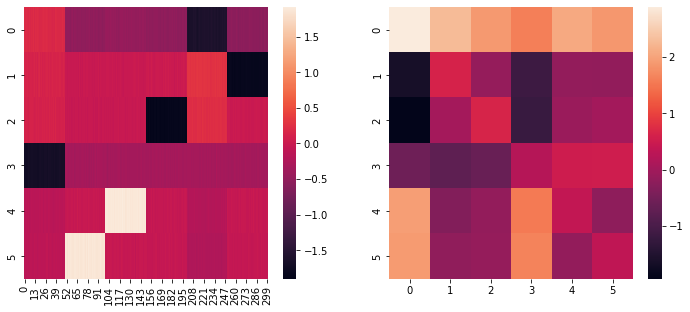

In [231]:
rtrbm = torch.load(open(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\Sampling rate\DELAY=1\rtrbm_downsampled_1', 'rb'))

_, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(rtrbm.W.cpu(), ax=ax[0])
sns.heatmap(rtrbm.U.cpu(), ax=ax[1])

print(torch.sum(rtrbm.W, 1), torch.sum(rtrbm.U, 1))
print(torch.mean(rtrbm.W[0, 0:2]), torch.std(rtrbm.W[0, 0:2]))
W = rtrbm.W.cpu()
U = rtrbm.U.cpu()